

## Infos d'install

  * conda install python=3.7.10  
  * conda install spacy=2.3.5  
  * python -m spacy download fr_core_news_sm   
  * conda install tensorflow-hub  
  * pip install --user tensorflow-text  
      *# WARNING: The script tensorboard.exe is installed in .. which is not on PATH*
   * télécharger https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3 dans tfhub


## Liens    
  * Questions keras sur les générateurs https://github.com/keras-team/keras/issues/3386
  * Custom generator https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
  * http://artelab.dista.uninsubria.it/res/research/papers/2020/2020-IVCNZ-Gallo-Food101.pdf  
  * http://cbonnett.github.io/Insight.html  
  * https://stackoverflow.com/questions/51696575/keras-cnn-add-text-as-additional-input-besides-image-to-cnn  
  * https://github.com/depshad/Deep-Learning-Framework-for-Multi-modal-Product-Classification/blob/master/camembert_train_predict.ipynb  
  * https://keras.io/examples/nlp/pretrained_word_embeddings/


In [42]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import cv2 # opencv
import datetime
import hashlib
import inspect
import pickle
import wget
import gzip
import time
import tqdm
import html
import sys
import os
import re
import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier

import tensorflow_text # Needed for sentencepiece
import tensorflow_hub as hub

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D,\
                                    Input, Embedding, GRU, Bidirectional, \
                                    Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
                                    BatchNormalization, concatenate
NB_ECHANTILLONS = 20000

# Données d'entrée (lecture seule)
X_TRAIN_CSV_FILE = "X_train_update.csv"
Y_TRAIN_CSV_FILE = "Y_train_CVw08PX.csv"
X_TEST_CSV_FILE = "X_test_update.csv"
NB_CLASSES = 27

# Données de travail et de sortie
OUTDIR = "modele_rakuten_out"

MULTILINGUAL_DIR = "tfhub/universal-sentence-encoder-multilingual-large-3"
MULTILINGUAL_LINK = "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"

def init_OUTDIR():
    """ 
    Initialise le répertoire où seront générés les fichiers.
    Les fichiers d'entrées y sont copiés après mélange, au cas où ils
    auraient un ordre particulier
    """
    xtrainfile = os.path.join(OUTDIR, os.path.basename(X_TRAIN_CSV_FILE))
    ytrainfile = os.path.join(OUTDIR, os.path.basename(Y_TRAIN_CSV_FILE))
    xtestfile = os.path.join(OUTDIR, os.path.basename(X_TEST_CSV_FILE))
    if os.path.isfile(xtrainfile) and os.path.isfile(ytrainfile) and \
       os.path.isfile(xtestfile):
        return
    print('Création des fichiers entrées après mélange (shuffle)')
    if not os.path.isdir(OUTDIR):
        os.makedirs(OUTDIR)
        if not os.path.isdir(OUTDIR):
            raise ValueError(f"Impossible de créer {OUTDIR}")
    dfx = pd.read_csv(X_TRAIN_CSV_FILE)
    dfy = pd.read_csv(Y_TRAIN_CSV_FILE)
    dfx, dfy = shuffle(dfx, dfy, random_state=51)
    dfx, dfy = shuffle(dfx, dfy, random_state=52)
    dfx.to_csv(xtrainfile)
    dfy.to_csv(ytrainfile)
    dfx = pd.read_csv(X_TEST_CSV_FILE)
    dfx = shuffle(dfx, random_state=53)
    dfx = shuffle(dfx, random_state=54)
    dfx.to_csv(xtestfile)

def image_path(row, subdir):
        f = "image_%d_product_%d.jpg" % (row.imageid, row.productid) 
        ff = os.path.join(os.getcwd(), "images", subdir, f)
        return ff if os.path.isfile(ff) else None
    
def get_y():
    """ Retourne les y (cibles) """
    init_OUTDIR()
    ytrainfile = os.path.join(OUTDIR, os.path.basename(Y_TRAIN_CSV_FILE))
    return pd.read_csv(ytrainfile)["prdtypecode"].astype(str)

    
def get_X_text(inputXfile=None):
    """
    Retourne une liste X de phrases pré-traitées à partir d'un dataframe
    inputXfile qui contient les colonnes "designation" et "description"
    (cette dernière possèdent des valeurs NA)
    """
    if inputXfile is None:
        inputXfile = os.path.join(OUTDIR, os.path.basename(X_TRAIN_CSV_FILE))
    f = re.sub(r"\.csv$", "_text.pkl", os.path.basename(inputXfile))
    xtextfile = os.path.join(OUTDIR, f)
    if os.path.isfile(xtextfile):
        with open(xtextfile, 'rb') as fd:
            return pickle.load(fd)
    print(f"Creation de {xtextfile}")
    init_OUTDIR()
    X = []
    df = pd.read_csv(inputXfile)
    for desi, desc in zip(df.designation, df.description):
        desistr = desi if type(desi) == str else ''
        descstr = desc if type(desc) == str else ''
        s = (desistr + '. DESCRIPTION: ' + descstr) if len(descstr) > 0 else desistr
        X.append(s)
    d = os.path.dirname(xtextfile)
    if not os.path.isdir(d):
        os.mkdir(d)
    pickle.dump(X, open(xtextfile, 'wb'))
    return X


def get_X_image_path(inputXfile=None):
    """
    Retourne une liste X de chemins des fichiers images à partir d'un
    dataframe inputXfile
    """
    if inputXfile is None:
        inputXfile = os.path.join(OUTDIR, os.path.basename(X_TRAIN_CSV_FILE))
    f = re.sub(r"\.csv$", "_image_path.pkl", os.path.basename(inputXfile))
    xpathfile = os.path.join(OUTDIR, f)
    if os.path.isfile(xpathfile):
        with open(xpathfile, 'rb') as fd:
            return pickle.load(fd)
    print(f"Creation de {xpathfile}")
    init_OUTDIR()
    df = pd.read_csv(inputXfile)
    subdir = "image_train" if 'train' in inputXfile else "image_test"
    X = list(df.apply(lambda x: image_path(x, subdir), axis=1))
    d = os.path.dirname(xpathfile)
    if not os.path.isdir(d):
        os.mkdir(d)
    pickle.dump(X, open(xpathfile, 'wb'))
    return X


def get_X_text_spacy_lemma(inputXfile=None):
    """
    Retourne une liste X de tokens créés par le tokenizer.lemma de Spacy
    """
    if inputXfile is None:
        inputXfile = os.path.join(OUTDIR, os.path.basename(X_TRAIN_CSV_FILE))
    f = re.sub(r"\.csv$", "_text_spacy_lemma.pkl",
               os.path.basename(inputXfile))
    xtokenfile = os.path.join(OUTDIR, f)
    if os.path.isfile(xtokenfile):
        with open(xtokenfile, 'rb') as fd:
            return pickle.load(fd)
    X_text = get_X_text(inputXfile)
    print(f"Tokenization de {len(X_text)} phrases")
    spacynlp = spacy.load("fr_core_news_sm")
    spacynlp.disable_pipes('tagger', 'parser', 'ner')
    X = []
    for sentence in tqdm.tqdm(X_text):
        sentence = re.sub(r"([?¿.!,:;])", r" \1 ", sentence) # Isole la ponctuation
        tokens = [x.lemma_ for x in spacynlp(sentence)]
        X.append(tokens)
    #X = np.array(X).reshape(len(X_text),-1)
    d = os.path.dirname(xtokenfile)
    if not os.path.isdir(d):
        os.mkdir(d)
    pickle.dump(X, open(xtokenfile, 'wb'))
    return X


def get_X_text_spacy_lemma_lower(inputXfile=None):
    """
    Retourne une liste X de tokens créés par le tokenizer.lemma de Spacy
    et transformation en caractètes minuscules
    """
    if inputXfile is None:
        inputXfile = os.path.join(OUTDIR, os.path.basename(X_TRAIN_CSV_FILE))
    f = re.sub(r"\.csv$", "_text_spacy_lemma_lower.pkl",
               os.path.basename(inputXfile))
    xtokenfile = os.path.join(OUTDIR, f)
    if os.path.isfile(xtokenfile):
        with open(xtokenfile, 'rb') as fd:
            return pickle.load(fd)
    X_raw = get_X_text_spacy_lemma(inputXfile)
    print(f"Mise en minuscule de {len(X_raw)} listes de tokens")
    X = []
    for sentence in tqdm.tqdm(X_raw):
        tokens = [x.lower() for x in sentence]
        X.append(tokens)
    d = os.path.dirname(xtokenfile)
    if not os.path.isdir(d):
        os.mkdir(d)
    pickle.dump(X, open(xtokenfile, 'wb'))
    return X


def get_X_text_embed_multilingual(inputXfile=None):
    """
    Retourne une liste X de vecteurs de plongement dans le modèle pre-entrainé
    "multilingual-large-3"
    """
    if not os.path.isdir(MULTILINGUAL_DIR):
        raise ValueError(f"Répertoire non trouvé {MULTILINGUAL_DIR}")
        
    if inputXfile is None:
        inputXfile = os.path.join(OUTDIR, os.path.basename(X_TRAIN_CSV_FILE))
    f = re.sub(r"\.csv$", "_text_embed_multilingual.pkl",
               os.path.basename(inputXfile))
    xembedfile = os.path.join(OUTDIR, f)
    if os.path.isfile(xembedfile):
        with open(xembedfile, 'rb') as fd:
            return pickle.load(fd)
    X_text = get_X_text(inputXfile)
    print(f"Chargement de {MULTILINGUAL_DIR}")
    embed = hub.load(MULTILINGUAL_DIR)
    print(f"Plongement de {len(X_text)} phrases")
    X = []
    for x in tqdm.tqdm(X_text):
        X.append(embed(x)) # phrase x traduite en vecteur embedding
    X = np.array(X).reshape(len(X_text),-1)
    d = os.path.dirname(xembedfile)
    if not os.path.isdir(d):
        os.mkdir(d)
    pickle.dump(X, open(xembedfile, 'wb'))
    return X


def plot_history(title, history):
    """
    Affiche les évolution par epoque de la perte et de l'accuracy
    """
    if len(history.history['loss']) <= 1:
        return
    plt.figure(figsize=(15,3))
    for i, s in enumerate(['loss', 'accuracy']):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history[s], 'bo', color='orange')
        plt.plot(history.history['val_' + s], 'b', color='blue')
        plt.title(f'{title}: {s} by epoch')
        plt.ylabel(s)
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='right')
    plt.show()

class RakutenBaseModel:
    """
    Classe de base héritée par les modèles
    """

    def __init__(self, name, fit_length=None):
            
        self.outdir = OUTDIR
        self.name = name
        self.batch_size = 32
        self.validation_split = 0.15
        self.fbestweights = os.path.join(self.outdir,
                                         self.name + '_bestweights.hdf5')
        if fit_length is not None:
            fprefix = os.path.join(self.outdir, f"{self.name}_{fit_length}")
            objectfile = fprefix + "_object.pkl"
            modelfile = fprefix + "_model.hdf5"
            if not os.path.isfile(objectfile):
                raise ValueError(f"Pas de fichier {objectfile}")
            print(f"Chargement de l'objet ({objectfile})")
            obj = pickle.load(open(objectfile, "rb"))
            objvars = vars(obj)
            for v in objvars:
                setattr(self, v, objvars[v])
            if os.path.isfile(modelfile):
                print(f"Chargement du modèle ({modelfile})")
                self.model = tf.keras.models.load_model(modelfile)
        return self

    def prt(self, msg):
        """ Imprime un message et met à jour la variable 'journal' """
        if not hasattr(self, 'journal'):
            self.journal = ''
        now = datetime.datetime.now().strftime("%Hh%Mmn")
        s = f"++ [{now}] {self.name}: {msg}"
        self.journal += s + '\n'
        print(s)

    def report(self, y_test=None, y_pred=None):
        """ Affiche un rapport """
        score = round(f1_score(y_test, y_pred, average='weighted'), 4)
        self.prt(f'w-f1-score = \033[1m{score}\033[0m\n')
        print(classification_report(y_test, y_pred))
        return score

    def get_model(self, off_start, off_end, input_file=None):
        inp, x = self.get_model_body(off_start, off_end, input_file)
        x = tf.keras.layers.Dense(NB_CLASSES, activation='softmax', name='dense_' + self.name)(x)
        return Model(inp, x)

    def preprocess_y_train(self, off_start, off_end, input_file=None):
        y_train = get_y()[off_start:off_end]
        self.fit_labels = {i: v for i, v in enumerate(sorted(list(set(y_train))))}
        assert len(self.fit_labels) == NB_CLASSES
        rv = {self.fit_labels[i]: i for i in self.fit_labels}
        y_train = np.array([rv[v] for v in y_train])
        return y_train

    def layer_name(self, s):
        self.layer_index += 1
        return f"{s}_{self.layer_index}_{self.name}"

    def compile_and_train_gen(self, X_train, y_train,
                              optimizer='adam',
                              epochs=10,
                              patience_stop=2, patience_lr=None,
                              class_weight=[],
                              callbacks=[]):
        self.prt("fit(): Début")
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_stop,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min')]
        if patience_lr is not None:
            callbacks += [tf.keras.callbacks.ReduceLROnPlateau(
                                monitor='val_loss', factor=0.1, patience=patience_lr, verbose=1)]

        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        self.model.compile(optimizer=optimizer,
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])
        history = self.model.fit(X_train, y_train,
                                 epochs = epochs,
                                 validation_split = self.validation_split,
#                                steps_per_epoch = traingen.n//traingen.batch_size,
#                                validation_data = valgen,
#                                validation_steps = valgen.n//valgen.batch_size,
                                callbacks = callbacks, class_weight = class_weight)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        plot_history(f"{self.name}", history)
        self.prt("fit(): Fin\n")
        return history
        
    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
         
        self.prt("predict(): Début")
        softmaxout = self.model.predict(X_test, verbose = 1)
        y_pred = [self.fit_labels[i] for i in np.argmax(softmaxout, axis=1)]
        self.prt("predict(): Fin\n")
        return y_pred
    
    def save(self):
        """ Sauvegarde sur disque """
        if not hasattr(self, 'fit_length') or self.fit_length == 0:
            self.prt("Il n'y a rien à sauvegarder, fit n'a pas été exécuté)")
            return None
        fprefix = os.path.join(self.outdir,
                         f"{self.name}_{self.fit_length}")
        if hasattr(self, "model") and hasattr(self.model, "save"):
            f = fprefix + "_model.hdf5"
            self.model.save(f)
            self.prt(f"Modèle sauvegardé dans {f}")
            self.model = None
        f = fprefix + "_object.pkl"
        tmpf = f + '_tmp'
        selfvars = vars(self)
        weaks = []
        for v in selfvars:
            try:
                pickle.dump(selfvars[v], open(tmpf, 'wb'))
            except:
                print("Pas de sauvegarde de ", v)
                weaks.append(v)
        for v in weaks:
            del(selfvars[v])
        if os.path.isfile(tmpf):
            os.remove(tmpf)
        pickle.dump(self, open(f, 'wb'))
        self.prt(f"Objet complet sauvegardé dans {f}")
        return f
    
    def evaluate(self, samples_number=-1, test_size=0.2, train_offset=0):
        """ Cycle complet fit + predict + report + save """
        if samples_number == -1: # On prend tous le  jeu d'entrainement
            samples_number = len(get_y()) - train_offset
        t0 = time.time()
        test_offset = int(samples_number * (1 - test_size))
        self.fit(train_offset, test_offset)
        y_test = get_y()[test_offset : train_offset + samples_number]
        y_pred = self.predict(test_offset, train_offset + samples_number)
        self.report(y_test, y_pred)
        t = int(time.time() - t0)
        self.prt(f"Evaluation exécutée en {t} secondes")
        self.save()
    
    def create_model(self):
        """ Création du modèle """
        t0 = time.time()
        nb = len(get_y())
        self.fit(0, nb)
        self.save()
        df = pd.read_csv(X_TEST_CSV_FILE)
        # ... faire un shuffle avant predict, remettre dans l'ordre ensuite
        y_pred = self.predict(0, df.shape[0], input_file=X_TEST_CSV_FILE)
        df['prdtypecode'] = y_pred
        csvfile = os.path.join(self.outdir, f"test_update_{self.name}.csv")
        df.to_csv(csvfile)
        t = int(time.time() - t0)
        self.prt(f"{csvfile} crée en {t} secondes")


++ [14h31mn] TextEmbed: Entrainement de 16000 échantillons
++ [14h31mn] TextEmbed: Nombre de mots max par phrase originel = 2551
++ [14h31mn] TextEmbed: Nombre de mots max par phrase utilisé  = 600
++ [14h31mn] TextEmbed: Taille du vocabulaire (nombre de mots) = 73792
++ [14h31mn] TextEmbed: fit(): Début
Epoch 1/50
425/425 [==============================] - 95s 223ms/step - loss: 2.9104 - accuracy: 0.1772 - val_loss: 2.4852 - val_accuracy: 0.4375
Epoch 2/50
425/425 [==============================] - 91s 215ms/step - loss: 1.6938 - accuracy: 0.5256 - val_loss: 1.4046 - val_accuracy: 0.6158
Epoch 3/50
425/425 [==============================] - 90s 212ms/step - loss: 1.0449 - accuracy: 0.7160 - val_loss: 1.3011 - val_accuracy: 0.6296
Epoch 4/50
425/425 [==============================] - 90s 213ms/step - loss: 0.6737 - accuracy: 0.8138 - val_loss: 1.1211 - val_accuracy: 0.6833
Epoch 5/50
425/425 [==============================] - 90s 212ms/step - loss: 0.4945 - accuracy: 0.8671 - val_loss:

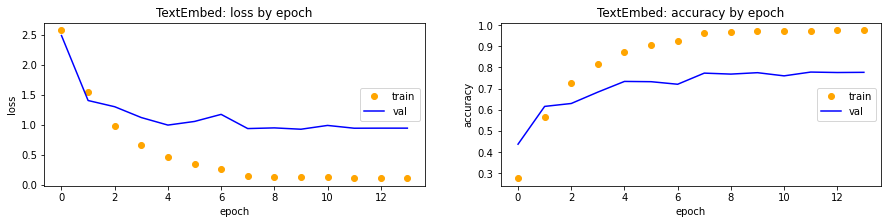

++ [14h52mn] TextEmbed: fit(): Fin

++ [14h52mn] TextEmbed: predict(): Début
4000/4000 [==============================] - ETA:  - 3s 660us/step
++ [14h53mn] TextEmbed: predict(): Fin

++ [14h53mn] TextEmbed: w-f1-score = 0.7654

              precision    recall  f1-score   support

          10       0.58      0.59      0.59       155
        1140       0.82      0.70      0.75       128
        1160       0.87      0.90      0.89       168
        1180       0.38      0.38      0.38        32
        1280       0.55      0.53      0.54       214
        1281       0.54      0.52      0.53        85
        1300       0.80      0.79      0.80       228
        1301       0.97      0.84      0.90        44
        1302       0.85      0.73      0.79       132
        1320       0.61      0.73      0.66       136
        1560       0.69      0.80      0.74       242
        1920       0.91      0.85      0.88       222
        1940       0.82      0.77      0.79        35
        2060  

In [17]:
class TextEmbed(RakutenBaseModel):
    """
    Modèle avec une première couche Embedding()
    """
    def __init__(self, fit_length=None):
        super().__init__(self.__class__.__name__, fit_length)
        self.maxsentwords = 600 # Nombre max de mots par phrase (tronquées)
        self.embeddim = 200   # Taille des vecteurs d'embedding
                              # 300 => 0.7996 pour 20000 maias ca depend des fois
                              # 200 => 0.7621      ""

    def get_model_body(self, off_start, off_end, input_file=None):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.maxsentwords,), name=self.layer_name("input"))
        x = tf.keras.layers.Embedding(input_dim=self.vocablen, output_dim=self.embeddim,
                                      input_length=self.maxsentwords,
                                      name=self.layer_name("embedding"))(inp)
        x = tf.keras.layers.GlobalAveragePooling1D(name=self.layer_name("GAvePool1D"))(x)
        x = tf.keras.layers.Dense(128, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        return inp, x

    def text_to_nparray(self, X):
        self.word2num = {w: i+1 for i, w in enumerate(self.vocab)}
        self.num2word = {self.word2num[w]: w for w in self.word2num}
        X_new = np.zeros((len(X), self.maxsentwords), dtype=int)
        for i, sentence in enumerate(X):
            for j, w in enumerate(sentence[:self.maxsentwords]):
                if w in self.word2num:
                    X_new[i,j] = self.word2num[w]
        return X_new
    
    def preprocess_X_train(self, off_start, off_end, input_file=None):
        self.prt(f"Entrainement de {self.fit_length} échantillons")
        X_train = get_X_text_spacy_lemma_lower(input_file)[off_start:off_end]
 
        maxnb = max([len(sent) for sent in X_train])
        self.prt(f"Nombre de mots max par phrase originel = {maxnb}")
        self.prt(f"Nombre de mots max par phrase utilisé  = {self.maxsentwords}")
        self.vocab = sorted(list({x for sentence in X_train \
                                                for x in sentence[:self.maxsentwords]}))
        self.vocablen = len(self.vocab) + 1 # +1 pour l'id 0 qui correspond au remplissage
        self.prt(f"Taille du vocabulaire (nombre de mots) = {self.vocablen}")
        X_train = self.text_to_nparray(X_train)
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text_spacy_lemma_lower(input_file)[off_start:off_end]
        X_test = self.text_to_nparray(X_test)
        return X_test

    def fit(self, off_start, off_end, input_file=None):
        self.fit_length = off_end - off_start
        X_train = self.preprocess_X_train(off_start, off_end, input_file)
        y_train = self.preprocess_y_train(off_start, off_end, input_file)
        
        self.model = self.get_model(off_start, off_end, input_file)
         
        return self.compile_and_train_gen(X_train, y_train, optimizer='adam',
                                         epochs=50, patience_stop=4, patience_lr=2,
                                         class_weight=[])


TextEmbed().evaluate(NB_ECHANTILLONS)


In [3]:
class TextOneHot(RakutenBaseModel):
    """
    Modèle NN exécuté après un préprocessing des données effectué
    avec un pipe sklearn <TfidfVectorizer | SelectFromModel(LinearSVC)>
    """
    def __init__(self, fit_length=None):
        super().__init__(self.__class__.__name__, fit_length)
        self.maxfeatures = 25000 # Nombre de features selectionnées par SVC
                
        self.select = make_pipeline(
            TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #stop_words=french_stop_words, 
                  # tokenizer=tokenize_spacy, mieux mais long
                  #lowercase=True,
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
 #                 max_features=30000,  moins rentable que celui de SelectFromModel 
                  ),
                  SelectFromModel(LinearSVC(penalty="l2", dual=True, C=0.8,
                                            tol=1e-5, max_iter=4000),
                                  max_features=self.maxfeatures))

    def get_model_body(self, off_start, off_end, input_file=None):
        self.layer_index = 0
        X_train = self.preprocess_X_train(off_start, off_end, input_file)
        inp = tf.keras.layers.Input(shape=X_train.shape[1:], name=self.layer_name("input"))
        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(inp)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        y_train_select = get_y()[off_start:off_end]
        X_train = get_X_text(input_file)[off_start:off_end]
        X_train = self.select.fit_transform(X_train, y_train_select).toarray()
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = self.select.transform(X_test).toarray()
        return X_test

    def fit(self, off_start, off_end, input_file=None):
        self.fit_length = off_end - off_start
        self.model = self.get_model(off_start, off_end, input_file)

        X_train = self.preprocess_X_train(off_start, off_end, input_file)
        y_train = self.preprocess_y_train(off_start, off_end, input_file)

        return self.compile_and_train_gen(X_train, y_train, optimizer='adam',
                                         epochs=50, patience_stop=5, patience_lr=3,
                                         class_weight=[])
        
TextOneHot().evaluate(NB_ECHANTILLONS)


In [4]:
class Multilingu(RakutenBaseModel):
    """
    Modèle de plongement (embedding) dans un modèle de texte préentrainé
    (Multilingual-large)
    """
    def __init__(self, fit_length=None):
        super().__init__(self.__class__.__name__, fit_length)
        self.embedding_length = 512 # Défini par le modèle Multilingual/large
        self.std = StandardScaler()

    def get_model_body(self, off_start, off_end, input_file=None):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.embedding_length,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(inp)
        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_train = self.std.fit_transform(X_train)
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_test = self.std.transform(X_test)
        return X_test

    def fit(self, off_start, off_end, input_file=None):
        self.fit_length = off_end - off_start
        self.model = self.get_model(off_start, off_end, input_file)

        X_train = self.preprocess_X_train(off_start, off_end, input_file)
        y_train = self.preprocess_y_train(off_start, off_end, input_file)
        
        return self.compile_and_train_gen(X_train, y_train, optimizer='adam',
                                         epochs=50, patience_stop=8, class_weight=[])
        

Multilingu().evaluate(NB_ECHANTILLONS)


In [5]:
# https://www.dlology.com/blog/transfer-learning-with-efficientnet/
class EffNet(RakutenBaseModel):
    """
    Modèle de transfert learning d'image avec EfficientNet et utilisation
    d'un générateur d'images augmentées
    """

    def __init__(self, fit_length=None):
        super().__init__(self.__class__.__name__, fit_length)

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def get_model_body(self, off_start, off_end, input_file=None):
        self.layer_index = 0
        self.input_shape = (240, 240, 3) # Dépend du numéro x (EfficientNetBx)
        self.preprocessing_function = None # Inclus dans le modèle qui attend des données [..255]
        self.basetrainable = 0 ### 20
        self.epochs_freezed = 6
        self.epochs_unfreezed = 1 #10
        self.batch_size = 32
        self.validation_split = 0.15
        self.basemodel = tf.keras.applications.EfficientNetB1(
                                input_shape = self.input_shape,
                                include_top = False,
                                # drop_connect_rate=0.4,
                                weights = 'imagenet')
        inp = Input(shape=self.input_shape, name="input_" + self.name)
        x = self.basemodel(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True,axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(512, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        return inp, x

    def get_train_dataset(self, X_imagepaths, y_train):
        df = pd.DataFrame({"imgpath": X_imagepaths, "class": y_train})
        datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    validation_split = self.validation_split,
                                    preprocessing_function = self.preprocessing_function,
                                    rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    brightness_range=[0.9, 1.1],
                                    horizontal_flip = True
                                    )
        traingen = datagenerator.flow_from_dataframe(subset = 'training', dataframe=df,
                                                     x_col="imgpath", y_col="class",
                                                     class_mode="sparse",
                                                     target_size=(self.input_shape[0], self.input_shape[1]),
                                                     batch_size=self.batch_size)
        valgen = datagenerator.flow_from_dataframe(subset='validation',
                                                   dataframe=df, x_col="imgpath", y_col="class",
                                                   class_mode="sparse",
                                                   target_size=(self.input_shape[0], self.input_shape[1]),
                                                   batch_size=self.batch_size)
        return traingen, valgen

    def get_test_dataset(self, X_imagepaths):
        df = pd.DataFrame({"imgpath": X_imagepaths,
                           "class": [0 for _ in range(len(X_imagepaths))]})
        testgen = tf.keras.preprocessing.image.ImageDataGenerator( 
                        preprocessing_function = self.preprocessing_function).flow_from_dataframe(
                        dataframe=df, x_col="imgpath", y_col="class",
                        class_mode=None, target_size=(self.input_shape[0], self.input_shape[1]),
                        batch_size=self.batch_size, # ?
                        shuffle = False)
        return testgen
    
    def compile_and_train(self, traingen, valgen, optimizer, patience, epochs):
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min')]
        self.model.compile(optimizer=optimizer,
                           loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen, epochs=epochs,
                                      steps_per_epoch = traingen.n//traingen.batch_size,
                                      validation_data = valgen,
                                      validation_steps = valgen.n//valgen.batch_size,
                                      callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        plot_history(f"{self.name}", history)

    def fit(self, off_start, off_end, input_file="X_train_update.csv"):
        self.fit_length = off_end - off_start
        self.prt(f"Entrainement avec {self.fit_length} échantillons")

        self.model = self.get_model(off_start, off_end, input_file)

        self.prt(f"Création des générateurs d'images")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        y_train = get_y()[off_start:off_end]
        traingen, valgen = self.get_train_dataset(X_imgpaths, y_train)
        self.fit_labels = dict((v,k) for k,v in (traingen.class_indices).items())
        
        self.prt(f"Congélation des layers du modèle de base et entrainement")
        for layer in self.basemodel.layers:
            layer.trainable = False
        history = self.compile_and_train(traingen, valgen,
                                         optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                                         patience=1,
                                         epochs=self.epochs_freezed)
        if self.basetrainable > 0:
            self.prt(f"Décongélation des {self.basetrainable} derniers layers et entrainement")
            for layer in self.basemodel.layers[-self.basetrainable:]:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
            self.compile_and_train(traingen, valgen,
                                   optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                                   patience=2,
                                   epochs=self.epochs_unfreezed)
        self.prt("Entrainement terminé")
        return history

    def predict(self, off_start, off_end, input_file="X_train_update.csv"):
        length = off_end - off_start
        self.prt(f"Prédiction de {length} échantillons")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        testgen = self.get_test_dataset(X_imgpaths)
        
        softmaxout = self.model.predict(testgen, verbose = 1)
        assert len(self.fit_labels) == NB_CLASSES
        y_pred = [self.fit_labels[i] for i in np.argmax(softmaxout, axis=1)]
        self.prt("Prédiction terminée")
        return y_pred

EffNet().evaluate(NB_ECHANTILLONS)


In [ ]:
class CatDataset(tf.keras.utils.Sequence):
    """
    Générateur de donnéees utilisé par un modèle à entrées multitles.
    Les données préprocessées Xs sont stockéees dans des fichiers qui
    seront lus à la demande (__getitem__). Chaque fichier contient les
    données d'un batch (pour tous les modèles de base).
    """
    def batch_filepath(self, index):
        return os.path.join(self.dir, f"batch_{index}.npy")

    def __init__(self, batch_size, objs,
                 off_start, off_end, Xs, y=None):
        length = off_end - off_start
        self.batch_size = batch_size
        if y is None:
            self.y = None
        else:
            self.y = y[off_start:off_end] # On garde que ce qui sert
        self.input_number = len(Xs)
        self.batch_number = int(length / batch_size)
        self.dir = os.path.join(OUTDIR, f"{self.__class__.__name__}_{off_start}_{length}")
        if not os.path.isdir(self.dir):
            os.makedirs(self.dir)
        else:
            print(f"Nettoyage de {self.dir}")
            for f in os.listdir(self.dir):
                os.remove(os.path.join(self.dir, f))
        print(f"Création de {self.batch_number} fichiers de batch dans {self.dir}")
        for i, X in enumerate(Xs):
            print(f"* modèle {objs[i].name}")
            X = X[off_start:off_end]
            isfile = type(X[0]) == str and os.path.isfile(X[0])
            for index in tqdm.tqdm(range(self.batch_number)):
                if not isfile:
                    X_batch = X[index*batch_size:(index+1)*batch_size, ...]
                else:
                    # Ce sont des fichiers images
                    X_batch = X[index*batch_size:(index+1)*batch_size]
                    imgs = list()
                    for f in X_batch:
                        img = cv2.imread(f)
                        img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
                        imgs.append(img)
                    X_batch = np.array(imgs)
                batchfile = self.batch_filepath(index)
                with open(batchfile, 'a+b') as f:
                    np.save(f, X_batch)

    def __len__(self):
        # Retourne le nombre de batchs
        return self.batch_number

    def __getitem__(self, index):
        # Retourne 1 batch, de forme
        # X=[(batchsize, X1), (batchsize, X2), ...], y= (batch_size,)
        batchfile = self.batch_filepath(index)
        X = list() # Liste des batches pour chacun des modèles
        with open(batchfile, 'rb') as f:
            for _ in range(self.input_number):
                objbatch = np.load(f)
                X.append(objbatch)
        if self.y is None:
            return X
        else:
            y = self.y[index*self.batch_size : (index+1)*self.batch_size]
            return X, y

    #def on_epoch_end(self):
        # option method to run some logic at the end of each epoch: e.g. reshuffling


class CatModel(RakutenBaseModel):
    """
    Modèle qui concatene plusieurs modèles de base
    """
    def __init__(self, fit_length=None):
        super().__init__(self.__class__.__name__, fit_length)

    def create_train_generators(self, off_start, off_end, input_file=None):
        self.prt(f"Preprocessing des données d'entrainement")
        X_train = []
        for obj in self.objs:
            X_train.append(obj.preprocess_X_train(off_start, off_end, input_file))
        y_train = self.preprocess_y_train(off_start, off_end, input_file)
        self.prt(f"Instantiation des générateurs d'entrainement")
        off_val = off_end - int((off_end - off_start) * self.validation_split)
        traingen = CatDataset(self.batch_size, self.objs,
                              off_start, off_val, X_train, y_train)
        valgen = CatDataset(self.batch_size, self.objs,
                            off_val, off_end, X_train, y_train)
        return traingen, valgen

    def create_test_generator(self, off_start, off_end, input_file=None):
        self.prt(f"Preprocessing des données de test")
        X_test = []
        for obj in self.objs:
            X_test.append(obj.preprocess_X_test(off_start, off_end, input_file))
        self.prt(f"Instantiation du générateur de test")
        testgen = CatDataset(1, self.objs, off_val, off_end, X_test)
        return testgen
        
    def fit(self, off_start, off_end, input_file=None):
        self.fit_length = off_end - off_start
        self.prt(f"Entrainement avec {self.fit_length} échantillons")

        self.prt(f"Chargements des modèles de base")
        # Liste des modèles de base et instanciation, en leur passant la
        # taille (fit_length) ce qui revient simplement à lire leurs
        # sauvegardes en fichier (il faut que les modèles aient don été
        # déjà exécutés et les fichiers créés)
        self.objs = [
#             TextEmbed(self.fit_length),
             TextOneHot(self.fit_length),
             Multilingu(self.fit_length),
             EffNet(self.fit_length)
        ]

        # Générateurs qui alimenteront fit() avec les données train & val
        traingen, valgen = self.create_train_generators(off_start, off_end, input_file)
        
        self.prt(f"Création du modèle")
        # Récupèration des inputs et des outputs de chaque modèle de base
        # pour construire le modèle concatenate
        inputlayers, outputlayers = [], []
        for obj in self.objs:
            inp, outp = obj.get_model_body(off_start, off_end, input_file)
            inputlayers.append(inp)
            outputlayers.append(outp)
        
        self.layer_index = 0 # compteur utilisé dans get_model_body()
        concatname = self.layer_name("concatenate")
        x = concatenate(outputlayers, axis=-1, name = concatname)
        x = Dense(64, activation='relu', name=self.layer_name("dense"))(x)
        x = Dropout(0.3, name=self.layer_name("dropout"))(x)
        x = Dense(NB_CLASSES, activation='softmax', name=self.layer_name("dense"))(x)
        self.model = Model(inputlayers, x, name=self.name)

        #print(self.model.summary())

        print(f"  * Layers non entrainables:")
        for layer in self.model.layers[:-3]:
            layer.trainable = False
            print(f"      - {layer.name}")
        print(f"  * Layers entrainables:")
        for layer in self.model.layers:
            if layer.trainable:
                print(f"      - {layer.name}")

        self.model.compile(optimizer= tf.keras.optimizers.Adam(lr=1e-3),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])

        print(f"  * Layers initialisés avec les poids des modèles de base:")
        # Copie des poids des layers de bases vers leurs clones (ayant le
        # même nom) du modèle concatenate
        for obj in self.objs:
            for oldlayer in obj.model.layers:
                weights = oldlayer.get_weights()
                if len(weights) > 0:
                    for newlayer in self.model.layers:
                        if newlayer.name == oldlayer.name:
                            print(f"      - {newlayer.name}")
                            newlayer.set_weights(weights)

        self.prt("fit(): Début")    
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min'),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1,
                                                          verbose=1)]
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=12,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        self.prt("fit(): Fin")
        plot_history(f"{self.name}", history)
        return history

    def predict(self, off_start, off_end, input_file=None):
        length = off_end - off_start
        self.prt(f"Prédiction pour {length} échantillons")
        testgen = self.create_test_generator(off_start, off_end, input_file)
         
        self.prt("predict(): Début")
        softmaxout = self.model.predict(testgen, verbose = 1)
        y_pred = [self.fit_labels[i] for i in np.argmax(softmaxout, axis=1)]
        self.prt("predict(): Fin\n")
        return y_pred
                                  
CatModel().evaluate(NB_ECHANTILLONS)

++ [22h05mn] CatModel: Entrainement avec 16000 échantillons
++ [22h05mn] CatModel: Chargements des modèles de base
Chargement de l'objet (modele_rakuten_out\TextOneHot_16000_object.pkl)
Chargement du modèle (modele_rakuten_out\TextOneHot_16000_model.hdf5)
Chargement de l'objet (modele_rakuten_out\Multilingu_16000_object.pkl)
Chargement du modèle (modele_rakuten_out\Multilingu_16000_model.hdf5)
Chargement de l'objet (modele_rakuten_out\EffNet_16000_object.pkl)
Chargement du modèle (modele_rakuten_out\EffNet_16000_model.hdf5)
++ [22h05mn] CatModel: Preprocessing des données d'entrainement
++ [22h06mn] CatModel: Instantiation des générateurs d'entrainement
Nettoyage de modele_rakuten_out\CatDataset_0_13600


  3%|██                                                                              | 11/425 [00:00<00:03, 104.04it/s]

Création de 425 fichiers de batch dans modele_rakuten_out\CatDataset_0_13600
* modèle TextOneHot


 37%|████████████████████████████▋                                                 | 156/425 [00:00<00:00, 1548.57it/s]

* modèle Multilingu


  0%|▏                                                                                 | 1/425 [00:00<01:15,  5.58it/s]

* modèle EffNet


 15%|███████████▉                                                                     | 11/75 [00:00<00:00, 106.59it/s]

Nettoyage de modele_rakuten_out\CatDataset_13600_2400
Création de 75 fichiers de batch dans modele_rakuten_out\CatDataset_13600_2400
* modèle TextOneHot


  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

* modèle Multilingu
* modèle EffNet


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:12<00:00,  5.82it/s]


++ [22h07mn] CatModel: Création du modèle
  * Layers non entrainables:
      - input_EffNet
      - efficientnetb1
      - input_1_TextOneHot
      - input_1_Multilingu
      - global_average_pooling2d_15
      - dense_2_TextOneHot
      - batchnorm_2_Multilingu
      - dense_1_EffNet
      - dropout_3_TextOneHot
      - dense_3_Multilingu
      - batchnorm_2_EffNet
      - dense_4_TextOneHot
      - dropout_4_Multilingu
      - dropout_3_EffNet
      - dropout_5_TextOneHot
      - dense_5_Multilingu
      - dense_4_EffNet
      - batchnorm_6_TextOneHot
      - dropout_6_Multilingu
      - batchnorm_5_EffNet
      - concatenate_1_CatModel
  * Layers entrainables:
      - dense_2_CatModel
      - dropout_3_CatModel
      - dense_4_CatModel
  * Layers initialisés avec les poids des modèles de base:
      - dense_2_TextOneHot
      - dense_4_TextOneHot
      - batchnorm_6_TextOneHot
      - batchnorm_2_Multilingu
      - dense_3_Multilingu
      - dense_5_Multilingu
      - efficientnetb1

In [ ]:

tf.keras.utils.plot_model(cat.model, "to_file=dot_img_file,
                          show_shapes=True)